[*********************100%***********************]  1 of 1 completed
2/2 [==============================] - 1s 13ms/step


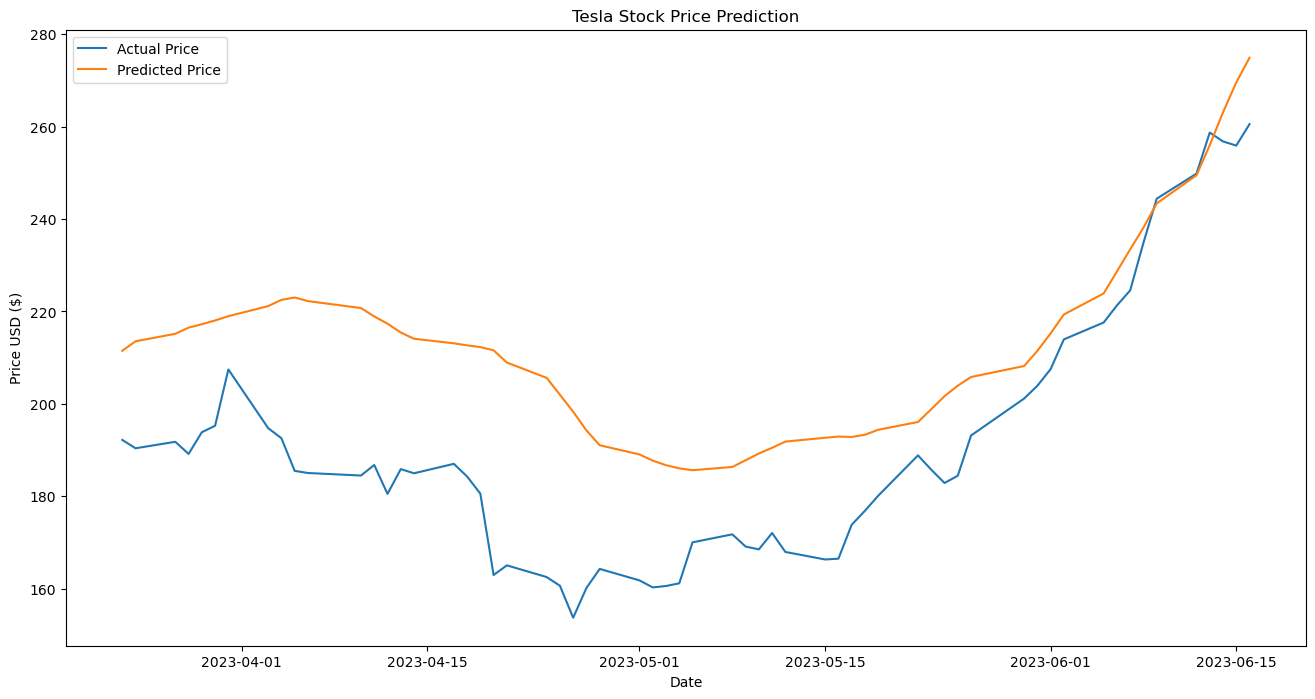

1/1 [==============================] - 0s 26ms/step
Predicted Closing Price for day 1: [[279.556]]
Predicted Closing Price for day 2: [[286.3502]]
Predicted Closing Price for day 3: [[293.56964]]
Predicted Closing Price for day 4: [[300.9979]]
Predicted Closing Price for day 5: [[308.48373]]


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# Define the stock symbol and date range
symbol = 'TSLA'
end_date = datetime.now()
start_date = end_date - timedelta(days=365*5)  # Five years ago

# Fetch the stock data
data = yf.download(symbol, start=start_date, end=end_date)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Define the training data
train_data = scaled_data[:len(data)-60]

# Create the x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# Test data set
test_data = scaled_data[len(train_data)-60:, :]

# Create the x_test and y_test data sets
x_test = []
y_test = data['Close'][len(train_data):].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert x_test to a numpy array 
x_test = np.array(x_test)

# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Getting the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Create dataframe for last 90 days
valid = data[len(train_data):].copy()  
valid.loc[:, 'Predictions'] = predictions

# Plot the data for last 90 days
plt.figure(figsize=(16,8))
plt.plot(valid[-90:][['Close', 'Predictions']])
plt.legend(["Actual Price", "Predicted Price"])
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()

# Get the most recent 60 day closing price values and scale the data to be values between 0 and 1
last_60_days = data['Close'][-60:].values
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))



# Prepare the feature set for the prediction
X_test = []
last_60_days = data['Close'][-60:].values.reshape(-1, 1)
last_60_days_scaled = scaler.transform(last_60_days)

X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the closing price for the next 5 days
predicted_prices = []

for i in range(5):
    pred_price = model.predict(X_test)
    predicted_prices.append(scaler.inverse_transform(pred_price))

    # Add the prediction to the end of the array and remove the first element
    X_test = np.insert(X_test[0], -1, pred_price, axis=0)
    X_test = np.delete(X_test, 0, axis=0)
    X_test = np.reshape(X_test, (1, X_test.shape[0], 1))

for i, price in enumerate(predicted_prices):
    print(f"Predicted Closing Price for day {i+1}: {price}")
